In [1]:
stock_1 = symbols('V')
stock_2 = symbols('MA')
start_date = '2016-1-1'
end_date = '2017-1-1'
HEDGE_LOOKBACK = 21

In [5]:
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as sm
import statsmodels.stats.diagnostic as sd
from scipy.stats import shapiro
from pykalman import KalmanFilter
import math
from scipy.stats import linregress
import itertools
from matplotlib import pyplot as plt

def run_kalman(price_history):
    kf_stock = KalmanFilter(transition_matrices = [1], observation_matrices = [1], initial_state_mean = price_history.values[0], 
                            initial_state_covariance = 1, observation_covariance=1, transition_covariance=.05)
    return kf_stock.smooth(price_history.values)[0].flatten()

s1_price = run_kalman(get_pricing(stock_1,start_date=start_date, end_date=end_date, start_offset=HEDGE_LOOKBACK).close_price)
s2_price = run_kalman(get_pricing(stock_2,start_date=start_date, end_date=end_date, start_offset=HEDGE_LOOKBACK).close_price)

def get_spreads(s1_price, s2_price):
    s1_price_changes = list(itertools.chain.from_iterable(pd.DataFrame(s1_price).pct_change(periods=HEDGE_LOOKBACK).iloc[HEDGE_LOOKBACK:].values.tolist()))
    s2_price_changes = list(itertools.chain.from_iterable(pd.DataFrame(s2_price).pct_change(periods=HEDGE_LOOKBACK).iloc[HEDGE_LOOKBACK:].values.tolist()))
    return np.array(s2_price_changes)-np.array(s1_price_changes)

spreads = get_spreads(s1_price, s2_price)

def correlation(a,b):
    return np.corrcoef(a,b)[0][1]
def cointegration(a, b):
    score, pvalue, _ = sm.coint(a, b)
    return pvalue
def adf_pvalue(spreads):
    return sm.adfuller(spreads,1)[1]
def hurst_hvalue(series):
    max_window = len(series)-1
    min_window = 10
    window_sizes = list(map(lambda x: int(10**x),np.arange(math.log10(min_window), math.log10(max_window), 0.25)))
    window_sizes.append(len(series))
    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(series), w):
            if (start+w)>len(series):
                break

        # RANDOM WALK
            incs = series[start:start+w][1:] - series[start:start+w][:-1]

            # SIMPLIFIED
            R = max(series[start:start+w]) - min(series[start:start+w])  # range in absolute values
            S = np.std(incs, ddof=1) 

            #NOT SIMPLIFIED
#             mean_inc = (series[start:start+w][-1] - series[start:start+w][0]) / len(incs)
#             deviations = incs - mean_inc
#             Z = np.cumsum(deviations)
#             R = max(Z) - min(Z)
#             S = np.std(incs, ddof=1)

        # PRICE
#             pcts = series[start:start+w][1:] / series[start:start+w][:-1] - 1.

#             #SIMPLIFIED
#             R = max(series[start:start+w]) / min(series[start:start+w]) - 1.
#             S = np.std(pcts, ddof=1)
        
        # CHANGE
#             incs = series
#             _series = np.hstack([[0.],np.cumsum(incs)])
#             R = max(_series) - min(_series)  # range in absolute values
#             S = np.std(incs, ddof=1)



            if R != 0 and S != 0:
                rs.append(R/S)
        RS.append(np.mean(rs))
    A = np.vstack([np.log10(window_sizes), np.ones(len(RS))]).T
    H, c = np.linalg.lstsq(A, np.log10(RS), rcond=-1)[0]
    return H
def half_life(spreads): 
    spreads = spreads[-HEDGE_LOOKBACK::]
    lag = np.roll(spreads, 1)
    #lag[0] = 0
    ret = spreads - lag
    #ret[0] = 0
    # return(-np.log(2) / np.polynomial.polynomial.polyfit(lag, ret, 1)[1])
    return(-np.log(2) / linregress(lag, ret).slope)

def shapiro_pvalue(spreads):
    w, p = shapiro(spreads)
    return p

def zscore(spreads):
    spreads = spreads[-HEDGE_LOOKBACK::]
    return abs((spreads[-1]-spreads.mean())/spreads.std())

def alpha(price1, price2):
    price1 = price1[-10::]
    price2 = price2[-10::]
    return linregress(price2, price1).slope

def ljung_box(spreads):
    return max(sd.acorr_ljungbox(spreads)[1])


correlation = correlation(s1_price, s2_price)
cointegration = cointegration(s1_price, s2_price)
adf_pvalue = adf_pvalue(spreads)
hurst_hvalue = hurst_hvalue(spreads)
half_life = half_life(spreads)
shapiro_pvalue = shapiro_pvalue(spreads)
zscore = zscore(spreads)
alpha = alpha(s1_price, s2_price)
ljung_box = ljung_box(spreads)

print(stock_1, stock_2)
print('Correlation',correlation)
print('Cointegration',cointegration)
print('ADF', adf_pvalue)
print('Hurst', hurst_hvalue)
print('Half Life', half_life)
print('Shapiro Wilk',shapiro_pvalue)
print('Zscore',zscore)
print('Alpha',alpha)
print('Ljung Box', ljung_box)

Equity(35920 [V]) Equity(32146 [MA])
Correlation 0.850325510438
Cointegration 1.0
ADF 1.22500898015e-11
Hurst 0.150054556249
Half Life 2.52259398472
Shapiro Wilk 8.98656367098738e-08
Zscore 1.92406089512
Alpha -0.742988044969
Ljung Box 8.00302072545e-57


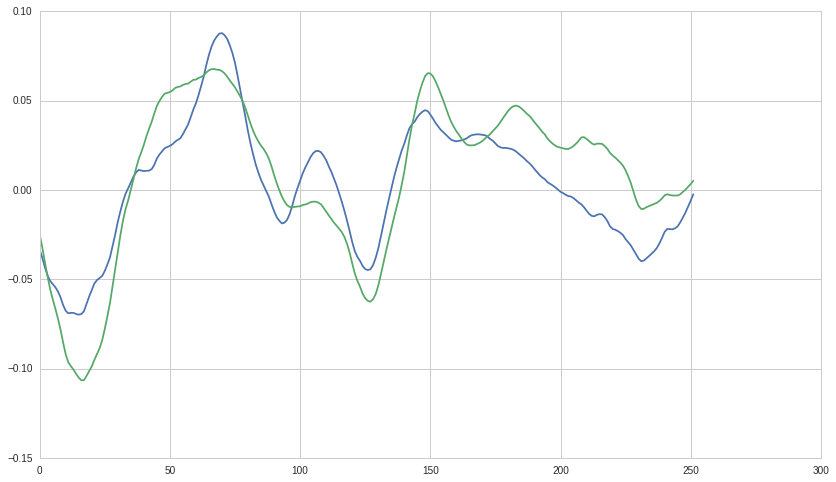

In [6]:
start_offset = HEDGE_LOOKBACK
s1_price = list(itertools.chain.from_iterable(pd.DataFrame(run_kalman(get_pricing(stock_1,start_date=start_date, end_date=end_date, start_offset=HEDGE_LOOKBACK).close_price)).pct_change(periods=HEDGE_LOOKBACK).iloc[HEDGE_LOOKBACK:].values.tolist()))
s2_price = list(itertools.chain.from_iterable(pd.DataFrame(run_kalman(get_pricing(stock_2,start_date=start_date, end_date=end_date, start_offset=HEDGE_LOOKBACK).close_price)).pct_change(periods=HEDGE_LOOKBACK).iloc[HEDGE_LOOKBACK:].values.tolist()))
plt.plot(s1_price)
plt.plot(s2_price)

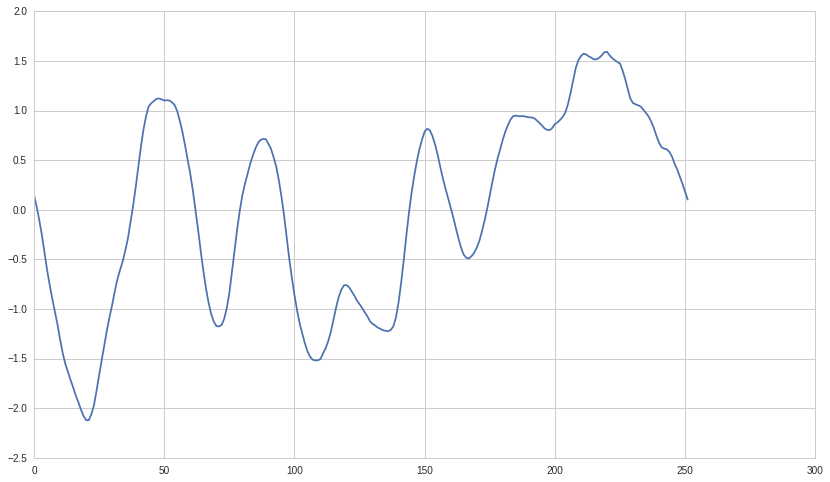

In [7]:
spreads = np.array(s2_price)-np.array(s1_price)
# plt.plot(spreads)

zscores = []
for i in range(len(spreads)):
    zscore = (spreads[i]-spreads.mean())/spreads.std()
    zscores.append(zscore)
plt.plot(zscores)

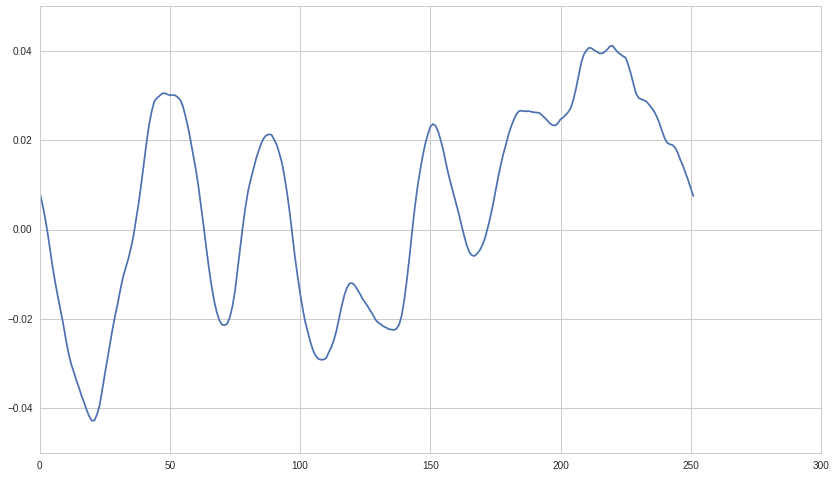

In [8]:
plt.plot(spreads)